# DrugEx API

An example DrugEx workflow showcasing some basic DrugEx API features. The API provides interface definitions to handle data operations and training of models needed for obtaining a molecule designer. The interface should ensure that the current code base is extensible and loosely coupled to make interoperability with different data sources seamless and to also aid in monitoring of the training processes involved.

Let's import and explain some of the important API features:

In [9]:
# main package
import drugex

# important classes for data access
from drugex.api.environ.data import ChEMBLCSV
from drugex.api.corpus import CorpusCSV, BasicCorpus, CorpusChEMBL

# important classes for QSAR modelling
# and (de)serialization of QSAR models
from drugex.api.environ.models import RF
from drugex.api.environ.serialization import FileEnvSerializer, FileEnvDeserializer

# classes that handle training of the exploration
# and exploitation networks and also handle monitoring 
# of the process 
from drugex.api.model.callbacks import BasicMonitor
from drugex.api.pretrain.generators import BasicGenerator

# ingredients needed for DrugEx agent training
from drugex.api.agent.agents import DrugExAgent
from drugex.api.agent.callbacks import BasicAgentMonitor
from drugex.api.agent.policy import PG

# designer API (wraps the agent after it was trained)
from drugex.api.designer.designers import BasicDesigner, CSVConsumer

Next let's define some global settings:

In [10]:
import torch

for device in range(torch.cuda.device_count()):
    print(device, torch.cuda.get_device_capability(device))

0 (3, 5)
1 (2, 1)
2 (3, 5)


In [11]:
import os

if torch.cuda.is_available():
    # choose a GPU device based on the info above
    # (the higher the capability, the better)
    torch.cuda.set_device(2)

DATA_DIR="data" # folder with input data files
OUT_DIR="output/workflow" # folder to store the output of this workflow
os.makedirs(OUT_DIR, exist_ok=True) # create the output folder

# define a set of gene IDs that are interesting for 
# the target that we want to design molecules for
GENE_IDS = ["ADORA2A"]

## Data Aquisition

It's time to aquire the data we will need for training of our models. There are three models that we need to build so we need three separate data sets:

1. Data for the exploitation model based on a random sample of 1 million molecules from the ZINC set.
2. Data for the exploration model based on ChEMBL data we downloaded for the desired target.
3. Data for the QSAR modelling of the environment model -> this model will bias the final generator towards more active molecules throug the a policy gradient.

### Exploitation Network

The exploitation network will be based on a large data set of known chemical structures. The ZINC database is a great source of data for the network:

In [12]:
# Randomly selected sample of 1 million molecules
# from the ZINC database.
# We only use this file for illustration purposes.
# In practice, the pretrained exploitation network should
# be provided so there will be no need for this data,
# but we are starting from square one here.
ZINC_CSV=os.path.join(DATA_DIR, "ZINC.txt")

# Load SMILES data into a corpus from a CSV file (we assume
# that we have the structures saved in a csv file in DATA_DIR).
# Corpus is a class which provides both the vocabulary and
# training data for a generator.
# This corupus will be used to train the exploitation network later.
corpus_pre = CorpusCSV(
    update_file=ZINC_CSV
    # The input CSV file with chemical structures as SMILES.
    # This is the only required parameter of this class.

    , vocabulary=drugex.VOC_DEFAULT
    # A vocabulary object that defines the tokens
    # and other options used to construct and parse SMILES.
    # VOC_DEFAULT is a reasonable "catch all" default.

    , smiles_column="CANONICAL_SMILES"
    # Instructs the corpus object what column to look for when
    # extracting SMILES to update the data.

    , sep='\t'
    # The column separator used in the CSV file
)

# Next we update the corpus (if we did not do it already).
# The updateData() method loads and tokenizes the SMILES it finds in the CSV.
# The tokenized data and updated vocabulary are returned to us.
corpus_out_zinc = os.path.join(OUT_DIR, "zinc_corpus.txt")
vocab_out_zinc = os.path.join(OUT_DIR, "zinc_voc.txt")
if not os.path.exists(corpus_out_zinc):
    df, voc = corpus_pre.updateData(update_voc=True, sample=1000)
    # We don't really use the return values here, but they are
    # still there if we need them for logging purposes or
    # something else. The update_voc flag tells the 
    # update method to also update the vocabulary
    # based on the tokens found in the SMILES strings.

    # We can save our corpus data if we want to reuse it later.
    # The CorpusCSV class has a methods
    # that we can use to save the vocabulary and tokenized data set.
    corpus_pre.saveCorpus(corpus_out_zinc)
    corpus_pre.saveVoc(vocab_out_zinc)
else:
    # If we initialized and saved
    # the corpus before, we just overwrite the
    # current one with the saved one
    corpus_pre= CorpusCSV.fromFiles(corpus_out_zinc, vocab_out_zinc)

Reading SMILES: 100%|██████████| 1000/1000 [00:00<00:00, 282425.70it/s]


### Exploration Network

We will also need a corpus for the exploration network. We will load it from ChEMBL using a different implementation of the Corpus interface than we saw above. When we update a CorpusChEMBL instance, it downloads the data for us automatically:

In [13]:
# CorpusChEMBL uses a list of gene identifiers
# and download activity data for all tested compounds
# related to the particular genes.
corpus_out_chembl = os.path.join(OUT_DIR, "chembl_corpus.txt")
vocab_out_chembl = os.path.join(OUT_DIR, "chembl_voc.txt")
env_data_path = os.path.join(OUT_DIR, "{0}.txt".format(GENE_IDS[0]))
if not os.path.exists(corpus_out_chembl):
    corpus_ex = CorpusChEMBL(GENE_IDS, clean_raw=True)

    # lets update this corpus and save the results
    # (same procedure as above)
    df, voc = corpus_ex.updateData(update_voc=True, sample=1000)
    corpus_ex.saveCorpus(corpus_out_chembl)
    corpus_ex.saveVoc(vocab_out_chembl)

    # in addition we will also save the raw downloaded data
    # (this is what we will also use as a basis for the environment QSAR model)
    corpus_ex.raw_data.to_csv(env_data_path, sep="\t", index=False)
else:
    # If we already generated the corpus file,
    # we can load it using the CorpusCSV class
    corpus_ex = CorpusCSV.fromFiles(corpus_out_chembl, vocab_out_chembl)

Found following target chembl IDs related to ADORA2A ['CHEMBL251']


Reading SMILES: 100%|██████████| 1000/1000 [00:00<00:00, 296186.99it/s]


Since in both cases we requested to update the vocabulary according to
tokens found in the underlying smiles for both the zinc
and ChEMBL corpus, we now need to unify them. Vocabularies
can be combined using the plus operator:

In [14]:
voc_all = corpus_pre.voc + corpus_ex.voc
corpus_pre.voc = voc_all
corpus_ex.voc = voc_all

If we did not do this, the exploitation and
exploration networks might not be compatible
and we would run into issues during modelling.

### Environment QSAR model

We also need activity data to
train the environment QSAR model which will provide the activity
values for policy gradient.
Luckily, we already have the file to do this:

In [15]:
environ_data = ChEMBLCSV(
    env_data_path # we got this file from ChEMBL thanks to CorpusChEMBL
    , 6.5 # this is the activity threshold for the pChEMBL value
    , id_col='MOLECULE_CHEMBL_ID' # column by which we group multiple results per molecule
)

The ChEMBLCSV class not only loads the activity data,
but also provides access to it for the
QSAR learning algorithms (see below).

## Model Training

### Exploitation Network

Training the exploitation generator takes a long time (we have over a million molecules in our ZINC sample)
so we would like to monitor
this process. We can use the Monitor
interface for that. The "BasicMonitor" just
saves log files and model checkpoints
in the given directory:

In [16]:
pr_monitor = BasicMonitor(
        out_dir=OUT_DIR
        , identifier="pr"
    )

TODO: it would be nice to also have a method in
the monitor that would stop the training process

However, we could easily implement our own monitor that could do a bit more than just what the basic monitor does. Here is an example:



In [37]:
from matplotlib import pyplot as plt
%matplotlib inline

class MyMonitor(BasicMonitor):
    
    def __init__(self, out_dir: str, identifier: str):
        super().__init__(out_dir, identifier)
        self.steps = []
        self.counter = 0

    def finalizeStep(
            self
            , *args
            , **kwargs
    ):
        super().finalizeStep(
            *args
            , **kwargs
        )
        self.counter += 1
        self.steps.append(self.counter)
        plt.plot(self.steps, self.loss_train)
        plt.savefig(os.path.join(self.out_dir, "net_{0}.png".format(self.identifier)))
        
    def close(self):
        super().close()
        plt.plot(self.steps, self.loss_train)
        plt.show()

In [38]:
pr_monitor = MyMonitor(
    out_dir=OUT_DIR
    , identifier="pr"
)

The monitor actually does more than just monitoring
of the process. It also keeps track of the best
model built yet and can be used to initialize
a generator based on that.
We use that feature below if there already is
a network state saved somewhere in our output directory:




Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Pretraining exploitation network...





Epoch:   3%|▎         | 1/30 [00:04<02:04,  4.29s/it]


Epoch:   7%|▋         | 2/30 [00:08<01:57,  4.20s/it]


Epoch:  10%|█         | 3/30 [00:12<01:50,  4.08s/it]


Epoch:  13%|█▎        | 4/30 [00:16<01:45,  4.05s/it]


Epoch:  17%|█▋        | 5/30 [00:19<01:40,  4.01s/it]


Epoch:  20%|██        | 6/30 [00:23<01:34,  3.96s/it]


Epoch:  23%|██▎       | 7/30 [00:27<01:27,  3.79s/it]


Epoch:  27%|██▋       | 8/30 [00:30<01:20,  3.65s/it]


Epoch:  30%|███       | 9/30 [00:34<01:17,  3.67s/it]


Epoch:  33%|███▎      | 10/30 [00:38<01:14,  3.74s/it]


Epoch:  37%|███▋      | 11/30 [00:42<01:13,  3.84s/it]


Epoch:  40%|████      | 12/30 [00:46<01:09,  3.88s/it]


Epoch:  43%|████▎     | 13/30 [00:50<01:06,  3.90s/it]


Epoch:  47%|████▋     | 14/30 [00:54<01:03,  3.94s/it]


Epoch:  50%|█████     | 15/30 [00:58<00:59,  3.95s/it]


Epoch:  53%|█████▎    | 16/30 [01:02<00:56,  4.02s/it]


Epoch:  57%|█████▋    | 17/30 [01:06<00:52,  4.02s/it]


Epoch:  60%|██████    | 18/30 [01:10<

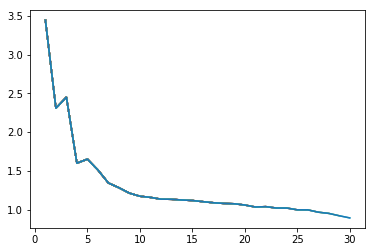

In [39]:
if not pr_monitor.getState(): # this will be False if the monitor cannot find an existing state
    print("Pretraining exploitation network...")
    pretrained = BasicGenerator(
        monitor=pr_monitor
        , corpus=corpus_pre
        , train_params={
            # these parameters are fed directly to the
            # fit method of the underlying pytorch model
            "epochs" : 30 # lets just make this one quick
        }
    )
    pretrained.pretrain()
    # This method also has parameters
    # regarding partioning of the training data.
    # We just use the defaults in this case.
else:
    pretrained = BasicGenerator(
        monitor=pr_monitor
        , initial_state=pr_monitor # the monitor provides initial state
        , corpus=corpus_pre
        # If we are not training this generator,
        # we could also omit this argument entirely.
        # If we did, the default vocabulary would be used
        # (not what we want now).
    )
    # we will not do any training this time,
    # but we could just continue by
    # specifying the training parameters and
    # calling pretrain again
    # TODO: maybe it would be nice if the monitor
    # keeps track of the settings as well

In [ ]:
# let's see if we can load the model from disk...
identifier = 'environ_rf'
des = FileEnvDeserializer(OUT_DIR, identifier)
try:
    # The deserializer automatically looks for
    # a model in the given directory with the given identifier
    environ_model = des.getModel()
    print("Model found at:", des.path)
    # return model
except FileNotFoundError:
    print("Training environment model...")

    # we choose the random forest algorithm
    environ_model = RF(train_provider=environ_data)
    environ_model.fit()
    # we save the model if we need it later
    # we also choose to save the performance data
    ser = FileEnvSerializer(OUT_DIR, identifier, include_perf=True)
    ser.saveModel(environ_model)